In [2]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F



import os 
import time
import cv2
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

rebuild_data = False

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
else:
    device = torch.device("cpu")
    
#i could assign specific layers to one gpu 

torch.cuda.device_count() #but i have only one :P
    

1

In [3]:
class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    
                    print(label)
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    #pass
                    print(str(e))
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
        

In [4]:
if rebuild_data:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

In [5]:
training_data = np.load("training_data.npy", allow_pickle = True)

In [6]:
(training_data[123][0].shape) #T p(xy),d p 0 thru 2000ish, d is e_i, 

(50, 50)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) 
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        #return x
        

In [8]:
net = Net()
#tensors on gpu interact only with tesors on the gpu
net.to(device)

torch.Size([128, 2, 2])


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [9]:
optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)

X.shape


torch.Size([24946, 50, 50])

In [17]:

X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
#now this is finally usable data


VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
#print(val_size)
print(X.view(-1,1,50,50).shape) #YOU WANT THIS GOING INTO FWD PASS
print(X.shape)

torch.Size([24946, 1, 50, 50])
torch.Size([24946, 50, 50])


In [11]:
train_X = X[:-val_size] 
train_y = y[:-val_size]

test_X = X[-val_size: ]
test_y = y[-val_size: ] #traaaaaaaaiin. test.


In [12]:
BATCH_SIZE = 1000

EPOCHS = 5

In [20]:
def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    
    outputs = net(X) #fed a batch in, got a batch of outputs
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs, y)] #careful about y's torchSize
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss



In [72]:

def test(size=32):
    
    random_start = np.random.randint(len(test_X)-size) #testing on  a random slice of data
    X, y = test_X[random_start: random_start+size], test_y[random_start: random_start+size]
    
    #im not call loss.backward or optimizer.step for test dataset
    with torch.no_grad():        
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
        return val_acc, val_loss

val_acc, val_loss = test(size=1000)  
print(val_acc, val_loss)
    

torch.Size([128, 2, 2])
0.779 tensor(0.1682, device='cuda:0')


In [ ]:
MODEL_NAME = f"model-{time.ctime((time.time()))}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)


def train():
    BATCH_SIZE = 100
    EPOCHS = 3
    
    with open("model.log", "a") as f:
        f.write(f"model, time, acc, loss, tacc, tloss\n")

        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True) #this is in_training_data accuracy and loss
                if i%50 == 0: #every 50 steps
                    val_acc, val_loss = test(size=100) #this is TEST_data accuracy and loss
                    f.write(f"{MODEL_NAME}, {round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss), 4)}, {round(val_acc, 2)}, {round(float(val_loss), 4)}, {epoch}\n")
                    #time-acc-loss-testAcc-testLoss-epoch
                    #f.write(str(round(float(val_loss), 4)) + "\n")
                    
train()                    
                

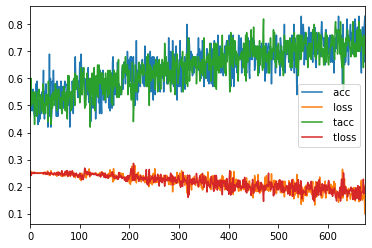

In [136]:
df = pd.read_csv('model.log')
df.shape
#help(df.loc)

#plt.subplot(1,2,1)
df[' acc'].plot(legend = True)
df[' loss'].plot(legend = True)
#plt.subplot(1,2,2)
df[' tacc'].plot(legend = True)
df[' tloss'].plot(legend = True)


In [4]:
torch.rand(2, 1, 4)*10

tensor([[[7.9219, 1.6207, 9.7338, 7.7646]],

        [[2.7582, 0.2535, 6.8382, 3.4549]]])